# 最も単純な方策勾配法
これまで見てきたのが価値関数を経由した価値ベースの手法。ここでは価値関数を経由しない、方策ベースの手法を見ていく。

In [1]:
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

class Policy(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x))
        return x

In [2]:
class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.pi)

    def get_action(self, state): # stateにおける行動を取り出す
        state = state[np.newaxis, :]  # バッチの軸を追加
        probs = self.pi(state)
        probs = probs[0]
        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]

    def add(self, reward, prob): # 報酬rと行動aをとる確率をメモリに保管
        data = (reward, prob)
        self.memory.append(data)

    def update(self): 
        self.pi.cleargrads()

        G, loss = 0, 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G

        for reward, prob in self.memory:
            loss += - F.log(prob) * G # 式に従って計算

        loss.backward()
        self.optimizer.update()
        self.memory = []  # メモリをリセット

In [3]:
env = gym.make('CartPole-v0')
agent = Agent()
reward_log = {}

for episode in range(3000):
    state = env.reset()
    done = False
    sum_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.add(reward, prob)
        state = next_state
        sum_reward += reward

    agent.update()

    reward_log[episode] = sum_reward
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, sum_reward))

episode :0, total reward : 40.0
episode :100, total reward : 18.0
episode :200, total reward : 32.0
episode :300, total reward : 17.0
episode :400, total reward : 30.0
episode :500, total reward : 51.0
episode :600, total reward : 39.0
episode :700, total reward : 23.0
episode :800, total reward : 44.0
episode :900, total reward : 73.0
episode :1000, total reward : 18.0
episode :1100, total reward : 30.0
episode :1200, total reward : 53.0
episode :1300, total reward : 38.0
episode :1400, total reward : 20.0
episode :1500, total reward : 52.0
episode :1600, total reward : 33.0
episode :1700, total reward : 69.0
episode :1800, total reward : 82.0
episode :1900, total reward : 73.0
episode :2000, total reward : 57.0
episode :2100, total reward : 140.0
episode :2200, total reward : 96.0
episode :2300, total reward : 132.0
episode :2400, total reward : 54.0
episode :2500, total reward : 98.0
episode :2600, total reward : 135.0
episode :2700, total reward : 72.0
episode :2800, total reward :

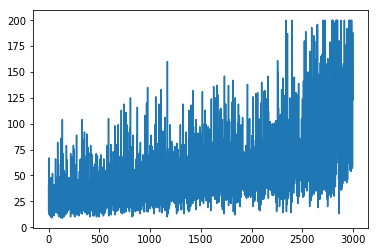

In [4]:
import matplotlib.pyplot as plt
plt.plot(reward_log.values())

# REINFORCE

In [5]:
class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.pi)

    def get_action(self, state):
        state = state[np.newaxis, :] 
        probs = self.pi(state)
        probs = probs[0]
        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]

    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        self.pi.cleargrads()

        G = 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G # Reinforceでは時刻tより前の報酬は考えない
            loss = - F.log(prob) * G
            loss.backward()
        self.optimizer.update()
        self.memory = []

In [6]:
env = gym.make('CartPole-v0')
agent = Agent()
reward_log = {}

for episode in range(3000):
    state = env.reset()
    done = False
    sum_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.add(reward, prob)
        state = next_state
        sum_reward += reward

    agent.update()

    reward_log[episode] = sum_reward
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, sum_reward))

episode :0, total reward : 15.0
episode :100, total reward : 74.0
episode :200, total reward : 35.0
episode :300, total reward : 24.0
episode :400, total reward : 26.0
episode :500, total reward : 32.0
episode :600, total reward : 151.0
episode :700, total reward : 108.0
episode :800, total reward : 200.0
episode :900, total reward : 34.0
episode :1000, total reward : 200.0
episode :1100, total reward : 200.0
episode :1200, total reward : 200.0
episode :1300, total reward : 200.0
episode :1400, total reward : 166.0
episode :1500, total reward : 165.0
episode :1600, total reward : 108.0
episode :1700, total reward : 183.0
episode :1800, total reward : 176.0
episode :1900, total reward : 200.0
episode :2000, total reward : 200.0
episode :2100, total reward : 200.0
episode :2200, total reward : 200.0
episode :2300, total reward : 188.0
episode :2400, total reward : 200.0
episode :2500, total reward : 200.0
episode :2600, total reward : 200.0
episode :2700, total reward : 200.0
episode :28

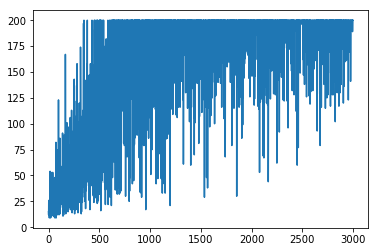

In [7]:
import matplotlib.pyplot as plt
plt.plot(reward_log.values())

# Actor-Critic

In [8]:
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L


class PolicyNet(Model):
    def __init__(self, action_size=2):
        super().__init__()
        self.l1 = L.Linear(256)
        self.l2 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = F.softmax(x)
        return x


class ValueNet(Model):
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(256)
        self.l2 = L.Linear(1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [9]:
class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr_pi = 0.0001
        self.lr_v = 0.0001
        self.action_size = 2

        self.pi = PolicyNet()
        self.v = ValueNet()
        self.optimizer_pi = optimizers.Adam(self.lr_pi).setup(self.pi)
        self.optimizer_v = optimizers.Adam(self.lr_v).setup(self.v)

    def get_action(self, state):
        state = state[np.newaxis, :]  # バッチ軸の追加
        probs = self.pi(state)
        probs = probs[0]
        action = np.random.choice([0, 1], p=probs.data)
        return action, probs[action]

    def update(self, state, action_prob, reward, next_state, done):
        state = state[np.newaxis, :]  # バッチ軸の追加
        next_state = next_state[np.newaxis, :]  # バッチ軸の追加

        # 価値関数のための損失関数
        td_target = reward + self.gamma * self.v(next_state) * (1 - done)
        td_target.unchain()
        v = self.v(state)
        loss_v = F.mean_squared_error(v, td_target)

        # 方策のための損失関数
        delta = td_target - v
        delta.unchain()
        loss_pi = -F.log(action_prob) * delta

        self.v.cleargrads()
        self.pi.cleargrads()
        loss_v.backward()
        loss_pi.backward()
        self.optimizer_v.update()
        self.optimizer_pi.update()

In [10]:
env = gym.make('CartPole-v0')
agent = Agent()
reward_log = {}

for episode in range(3000):
    state = env.reset()
    done = False
    sum_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.update(state, prob, reward, next_state, done)

        state = next_state
        sum_reward += reward

    reward_log[episode] = sum_reward
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, sum_reward))

episode :0, total reward : 23.0
episode :100, total reward : 8.0
episode :200, total reward : 10.0
episode :300, total reward : 10.0
episode :400, total reward : 10.0
episode :500, total reward : 8.0
episode :600, total reward : 10.0
episode :700, total reward : 10.0
episode :800, total reward : 8.0
episode :900, total reward : 9.0
episode :1000, total reward : 9.0
episode :1100, total reward : 9.0
episode :1200, total reward : 11.0
episode :1300, total reward : 81.0
episode :1400, total reward : 56.0
episode :1500, total reward : 135.0
episode :1600, total reward : 142.0
episode :1700, total reward : 190.0
episode :1800, total reward : 158.0
episode :1900, total reward : 200.0
episode :2000, total reward : 200.0
episode :2100, total reward : 200.0
episode :2200, total reward : 69.0
episode :2300, total reward : 198.0
episode :2400, total reward : 150.0
episode :2500, total reward : 186.0
episode :2600, total reward : 135.0
episode :2700, total reward : 104.0
episode :2800, total rewar